# Support Vector Regression (SVR) on Servo Dataset

This notebook implements SVR on the servo dataset which contains data about a servo system. The task is to predict the rise time of the servo mechanism based on two continuous gain settings and two discrete mechanical linkage choices.

## 1. Import Required Libraries

First, let's import all the necessary libraries for data loading, preprocessing, modeling, and visualization.

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

np.random.seed(42)

plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.2)

## 2. Load and Explore the Dataset

Let's load the servo dataset and explore its structure.

In [67]:
column_names = ['motor', 'screw', 'pgain', 'vgain', 'class']

try:
    df = pd.read_csv('data/servo.data', header=None, names=column_names)
except FileNotFoundError:
    df = pd.read_csv('../data/servo.data', header=None, names=column_names)

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (167, 5)


,motor,screw,pgain,vgain,class
0,E,E,5,4,0.281251
1,B,D,6,5,0.506252
2,D,D,4,3,0.356251
3,B,A,3,2,5.500033
4,D,B,6,5,0.356251


In [68]:
df.describe(include='all')

,motor,screw,pgain,vgain,class
count,167,167,167.000000,167.000000,167.000000
unique,5,5,NaN,NaN,NaN
top,C,A,NaN,NaN,NaN
freq,40,42,NaN,NaN,NaN
mean,NaN,NaN,4.155689,2.538922,1.389708
std,NaN,NaN,1.017770,1.369850,1.559635
min,NaN,NaN,3.000000,1.000000,0.131250
25%,NaN,NaN,3.000000,1.000000,0.503126
50%,NaN,NaN,4.000000,2.000000,0.731254
75%,NaN,NaN,5.000000,4.000000,1.259369


In [69]:
print("Missing values:")
df.isnull().sum()

Missing values:


motor    0
screw    0
pgain    0
vgain    0
class    0
dtype: int64

## 3. Exploratory Data Analysis

Let's visualize the data to better understand the relationships between features and the target variable.

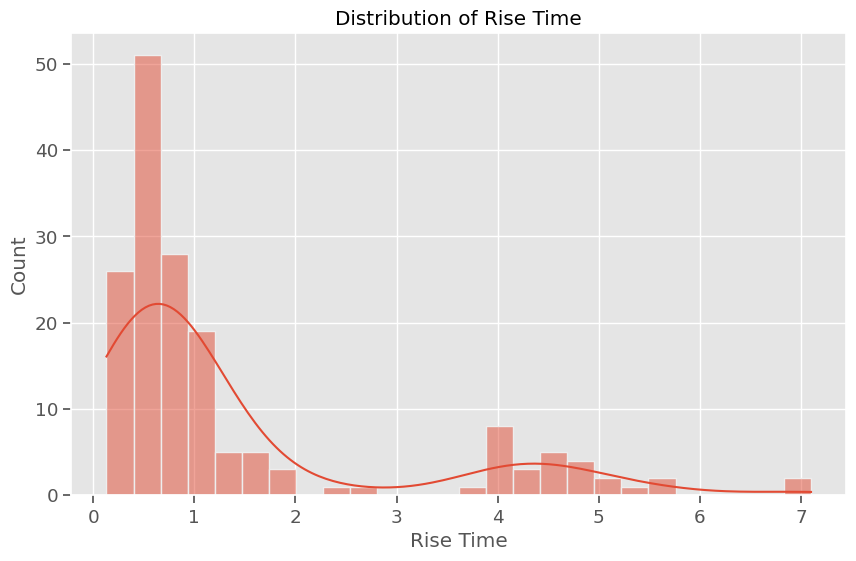

In [70]:
plt.figure(figsize=(10, 6))
sns.histplot(df['class'], kde=True)
plt.title('Distribution of Rise Time')
plt.xlabel('Rise Time')
plt.show()

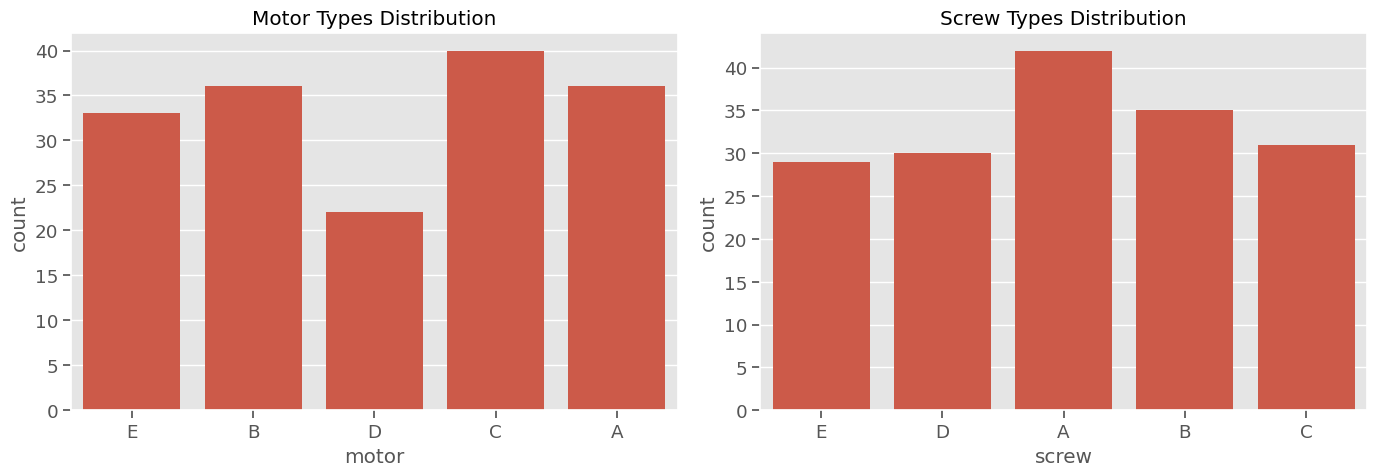

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.countplot(x='motor', data=df, ax=axes[0])
axes[0].set_title('Motor Types Distribution')
sns.countplot(x='screw', data=df, ax=axes[1])
axes[1].set_title('Screw Types Distribution')
plt.tight_layout()
plt.show()

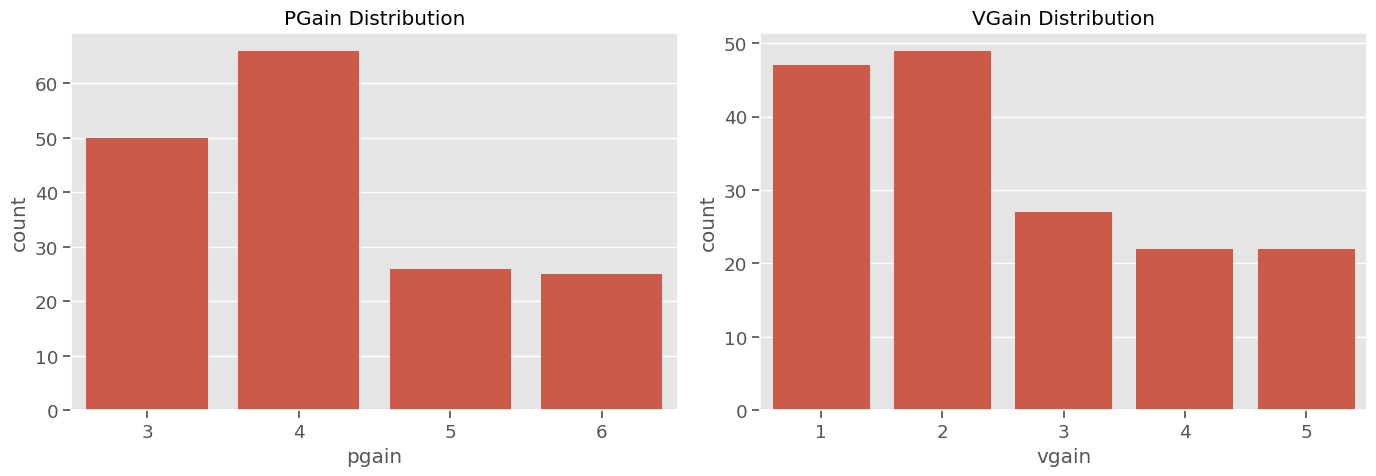

In [72]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.countplot(x='pgain', data=df, ax=axes[0])
axes[0].set_title('PGain Distribution')
sns.countplot(x='vgain', data=df, ax=axes[1])
axes[1].set_title('VGain Distribution')
plt.tight_layout()
plt.show()

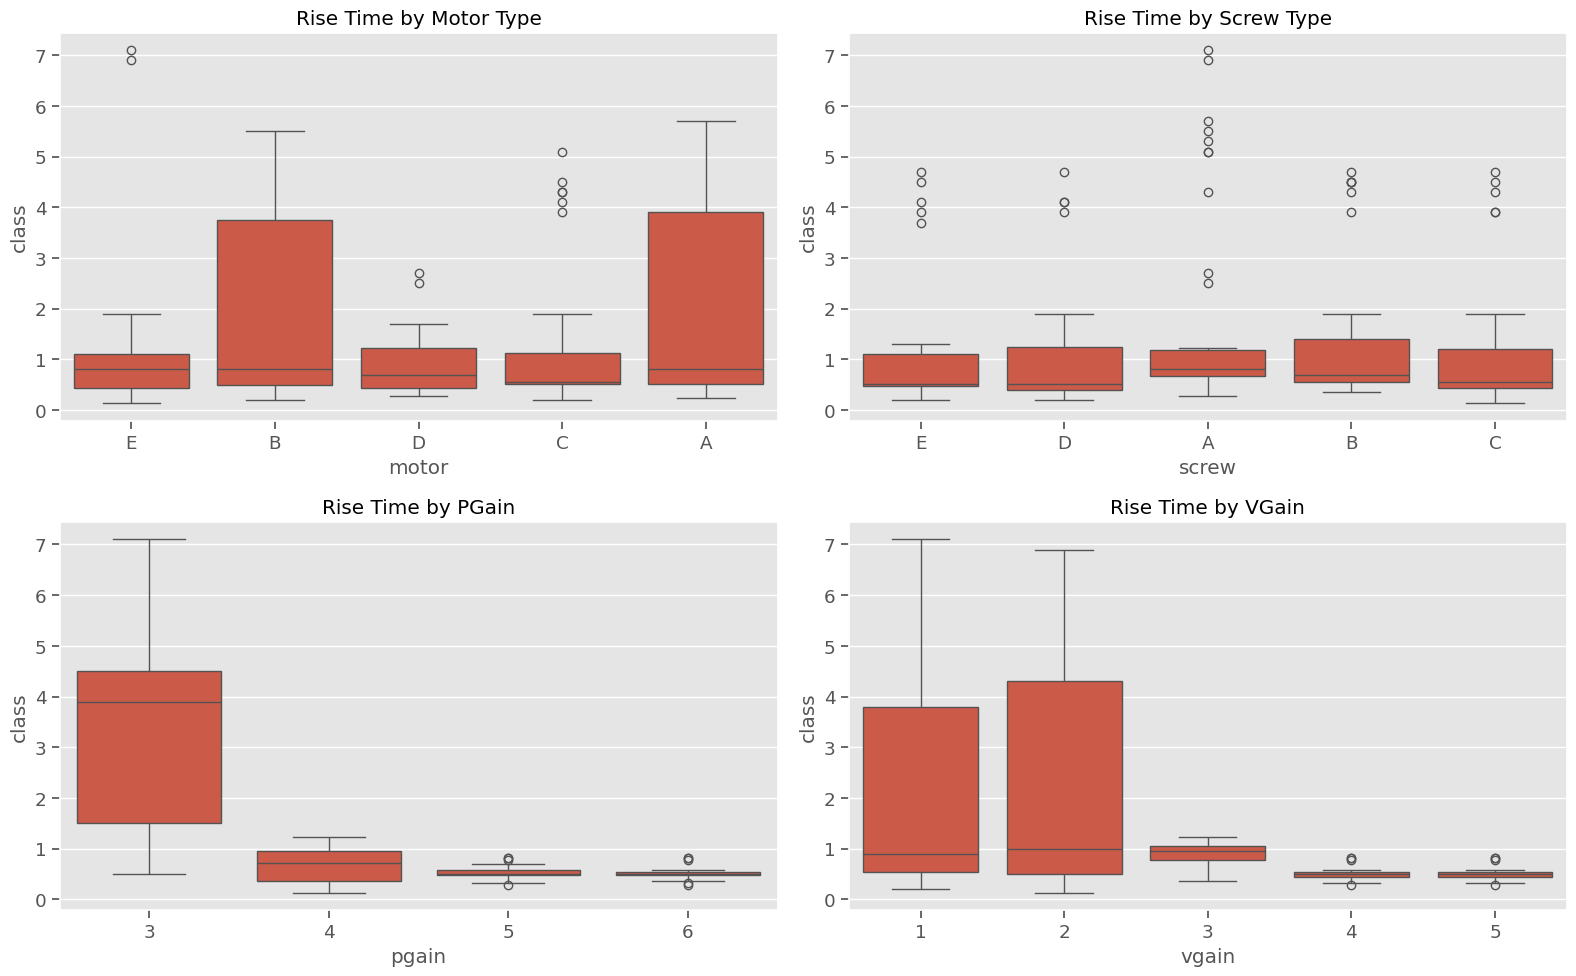

In [73]:
# Boxplot: Target value by categorical variables
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
sns.boxplot(x='motor', y='class', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Rise Time by Motor Type')
sns.boxplot(x='screw', y='class', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Rise Time by Screw Type')
sns.boxplot(x='pgain', y='class', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Rise Time by PGain')
sns.boxplot(x='vgain', y='class', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Rise Time by VGain')
plt.tight_layout()
plt.show()

## 4. Data Preprocessing

Now let's preprocess the data for modeling. We need to handle the categorical variables using one-hot encoding.

In [74]:
X = df.drop('class', axis=1)
y = df['class']

categorical_cols = ['motor', 'screw']
numerical_cols = ['pgain', 'vgain']

X['pgain'] = pd.to_numeric(X['pgain'])
X['vgain'] = pd.to_numeric(X['vgain'])

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 133 samples
Testing set size: 34 samples


In [76]:
# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ])

preprocessor.fit(X_train)
X_train_processed_sample = preprocessor.transform(X_train.iloc[:5])

ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = list(ohe_feature_names) + numerical_cols

print("Feature names after preprocessing:")
print(all_feature_names)

Feature names after preprocessing:
['motor_B', 'motor_C', 'motor_D', 'motor_E', 'screw_B', 'screw_C', 'screw_D', 'screw_E', 'pgain', 'vgain']


## 5. Support Vector Regression Implementation

Let's implement the SVR model and optimize its hyperparameters using GridSearchCV.

In [77]:
import time
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV

# Create the SVR pipeline
svr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', SVR())
])

# Define hyperparameter grid for SVR
param_grid = {
    'regressor__kernel': ['linear', 'rbf', 'poly'],
    'regressor__C': [0.01, 0.1, 1, 10, 100],
    'regressor__epsilon': [0.001, 0.01, 0.1, 0.2, 0.5],
    'regressor__gamma': ['scale', 'auto', 0.01, 0.1, 1.0],
    'regressor__degree': [2, 3],
    'regressor__coef0': [0.0, 1.0],
    'regressor__shrinking': [True, False]
}

# Print the total number of combinations
total_combinations = 3 * 5 * 5 * 5 * 2 * 2 * 2
print(f"Total parameter combinations: {total_combinations}")
print(f"Starting grid search at {datetime.now().strftime('%H:%M:%S')}")

# Choose which search method to use
use_randomized_search = True  # Set to False to use full grid search

if use_randomized_search:
    # Use RandomizedSearchCV for more efficient search
    print("Using RandomizedSearchCV with 100 iterations instead of full grid search")
    start_time = time.time()
    
    search = RandomizedSearchCV(
        svr_pipeline,
        param_distributions=param_grid,
        n_iter=100,  # Sample 100 parameter combinations
        cv=5,
        scoring='neg_mean_squared_error',
        verbose=2,  # More verbose output
        n_jobs=-1,
        random_state=42
    )
else:
    # Use full GridSearchCV (may take a long time)
    print("Using full GridSearchCV with all parameter combinations")
    start_time = time.time()
    
    search = GridSearchCV(
        svr_pipeline,
        param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        verbose=2,  # More verbose output
        n_jobs=-1
    )

# Fit the search
search.fit(X_train, y_train)

# Calculate and print execution time
end_time = time.time()
execution_time = end_time - start_time
print(f"\nSearch completed at {datetime.now().strftime('%H:%M:%S')}")
print(f"Total execution time: {execution_time:.2f} seconds ({execution_time/60:.2f} minutes)")

# Get the best parameters and best score
print("\nBest parameters:", search.best_params_)
print("Best cross-validation score: {:.4f}".format(-search.best_score_))

# Assign to grid_search for use in subsequent cells
grid_search = search

Total parameter combinations: 3000
Starting grid search at 22:31:17
Using RandomizedSearchCV with 100 iterations instead of full grid search
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Search completed at 22:31:27
Total execution time: 10.61 seconds (0.18 minutes)

Best parameters: {'regressor__shrinking': False, 'regressor__kernel': 'rbf', 'regressor__gamma': 0.1, 'regressor__epsilon': 0.1, 'regressor__degree': 3, 'regressor__coef0': 0.0, 'regressor__C': 100}
Best cross-validation score: 0.6319


In [78]:
# Get the best model
best_svr = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_svr.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error: 0.1122
Root Mean Squared Error: 0.3349
Mean Absolute Error: 0.2722
R² Score: 0.9536


## 6. Visualize Model Performance

Let's visualize how well our model predictions match the actual values.

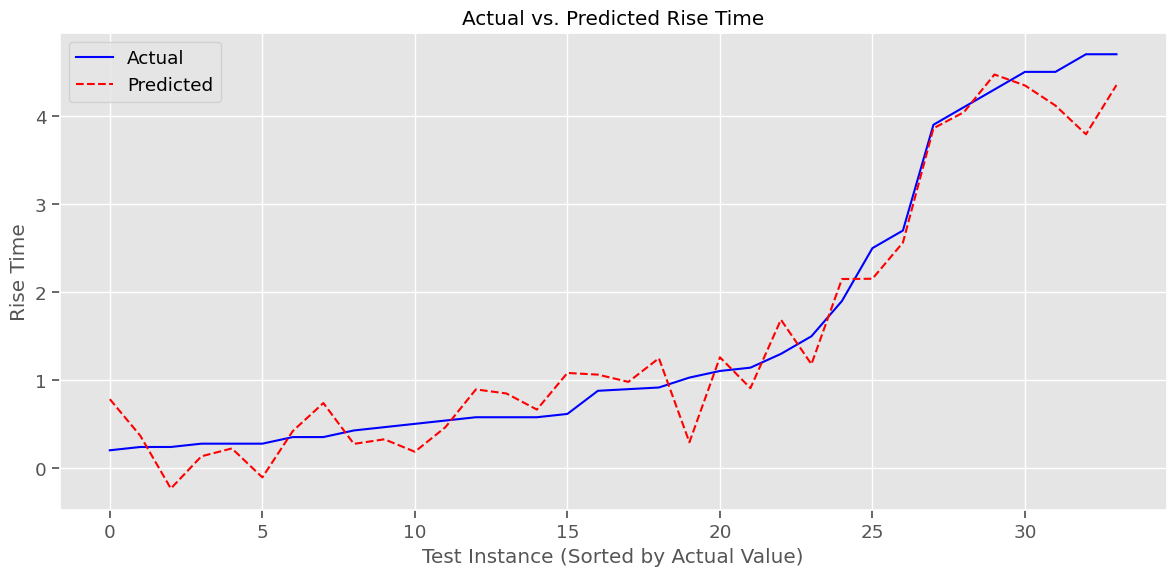

In [79]:
# Create a dataframe with actual and predicted values
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Sort by actual values for better visualization
results_df = results_df.sort_values(by='Actual')

# Plot actual vs. predicted
plt.figure(figsize=(12, 6))
plt.plot(results_df['Actual'].values, 'b-', label='Actual')
plt.plot(results_df['Predicted'].values, 'r--', label='Predicted')
plt.title('Actual vs. Predicted Rise Time')
plt.xlabel('Test Instance (Sorted by Actual Value)')
plt.ylabel('Rise Time')
plt.legend()
plt.tight_layout()
plt.show()

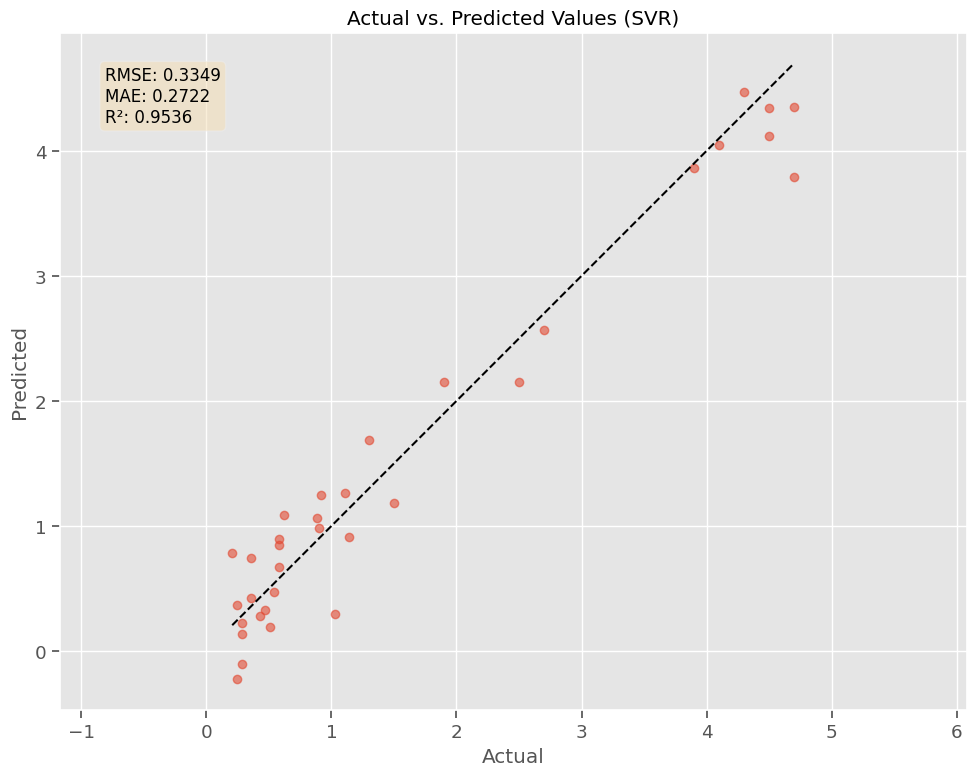

In [80]:
# Create a scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values (SVR)')

# Calculate the range for aspect ratio
range_actual = y_test.max() - y_test.min()
range_pred = y_pred.max() - y_pred.min()
plt.axis('equal')
plt.grid(True)

# Add text box with metrics
textstr = f'\n'.join((
    f'RMSE: {rmse:.4f}',
    f'MAE: {mae:.4f}',
    f'R²: {r2:.4f}'
))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

## 7. Residual Analysis

Let's analyze the residuals (prediction errors) to check for patterns or bias in our model.

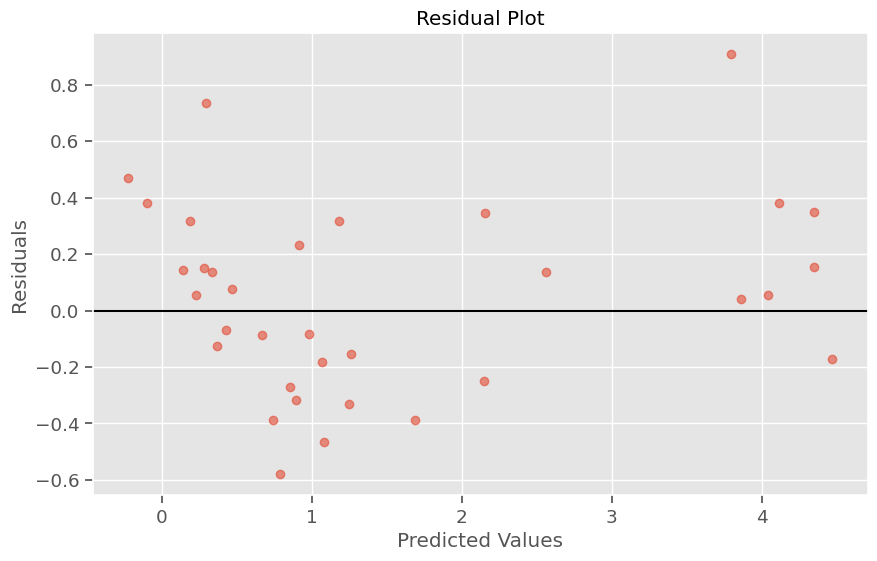

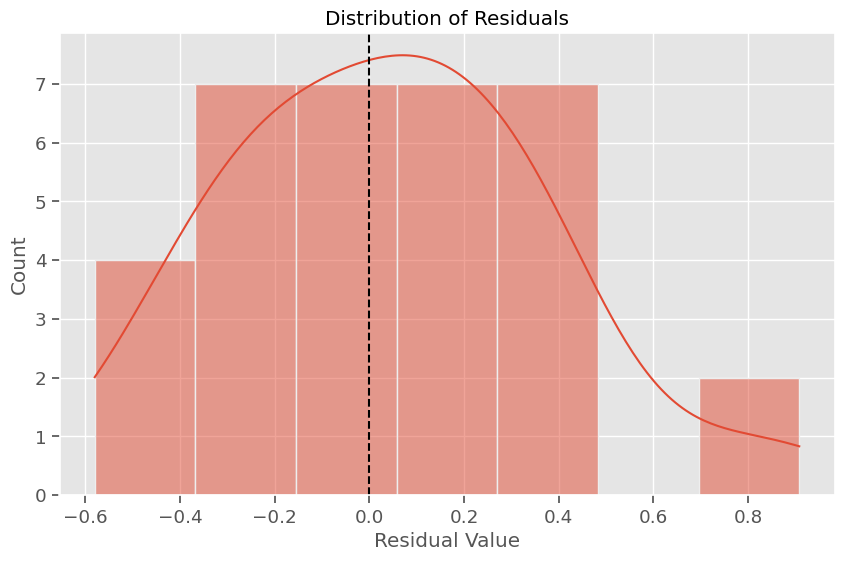

In [81]:
# Calculate residuals
residuals = y_test - y_pred

# Create a residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='k', linestyle='-')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

# Distribution of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residual Value')
plt.axvline(x=0, color='k', linestyle='--')
plt.show()

## 8. Feature Importance Analysis

Let's try to understand which features are most important for our SVR model. For non-linear kernels like RBF, direct feature importance is not available, but we can use a linear kernel to get some insights.

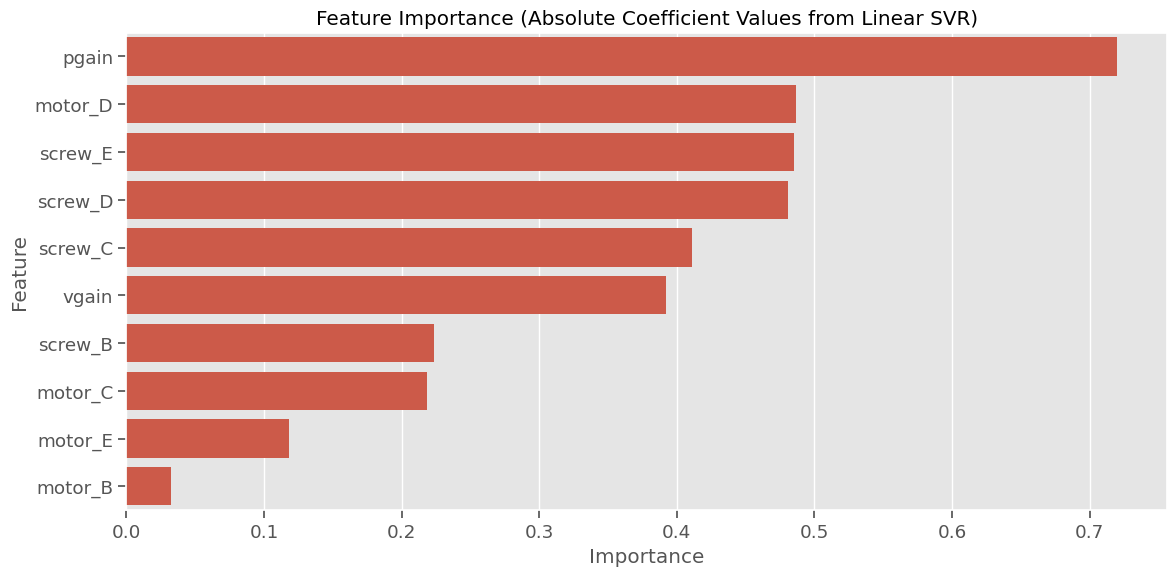

In [82]:
# Create a linear SVR to analyze feature importance
linear_svr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', SVR(kernel='linear', C=1.0))
])

# Train the model
linear_svr_pipeline.fit(X_train, y_train)

# Extract feature importances (coefficients) from the linear SVR
linear_svr = linear_svr_pipeline.named_steps['regressor']
feature_importances = linear_svr.coef_[0]

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': np.abs(feature_importances)
}).sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance (Absolute Coefficient Values from Linear SVR)')
plt.tight_layout()
plt.show()

## 9. Conclusion and Model Summary

Our SVR model has been trained and evaluated on the servo dataset. Here's a summary of the findings:

Support Vector Regression Model Summary
----------------------------------------
Best Parameters: {'regressor__shrinking': False, 'regressor__kernel': 'rbf', 'regressor__gamma': 0.1, 'regressor__epsilon': 0.1, 'regressor__degree': 3, 'regressor__coef0': 0.0, 'regressor__C': 100}
Cross-Validation RMSE: 0.7949
Test Set RMSE: 0.3349
Test Set MAE: 0.2722
Test Set R²: 0.9536
----------------------------------------

Comparison with other methods:
                    Method  Relative Error
0            Guessing mean         1.00000
1           Instance-based         0.26000
2               Regression         0.49000
3              Model trees         0.29000
4  Neural nets (G. Hinton)         0.11000
5     Regression+instances         0.20000
6    Model trees+instances         0.17000
7             NN+instances         0.11000
8            Our SVR model         0.23666


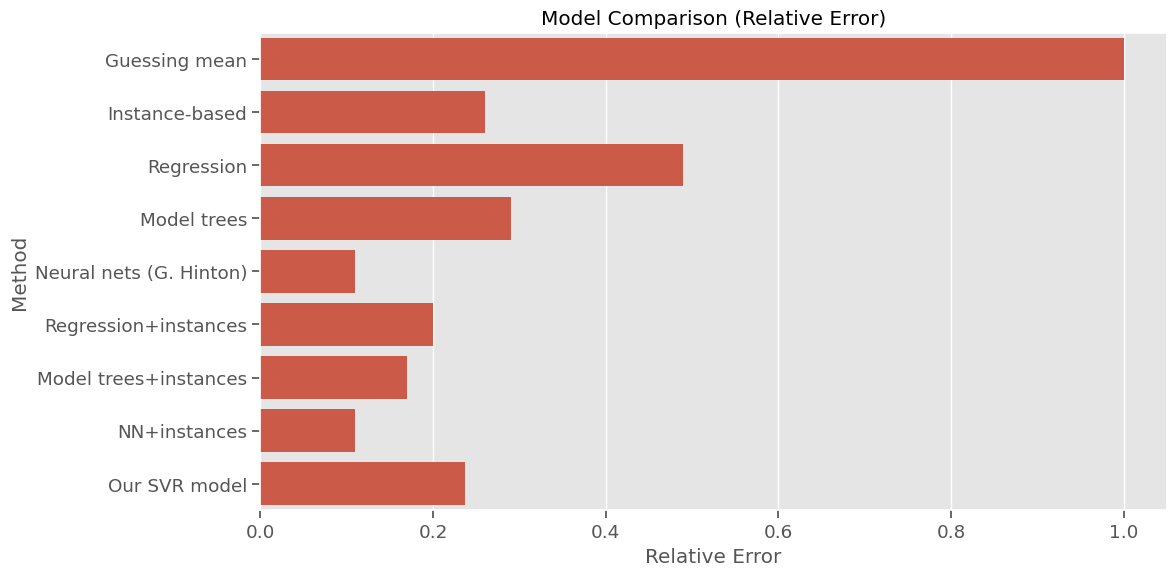

In [83]:
# Print a summary of model performance
print("Support Vector Regression Model Summary")
print("-" * 40)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Cross-Validation RMSE: {np.sqrt(-grid_search.best_score_):.4f}")
print(f"Test Set RMSE: {rmse:.4f}")
print(f"Test Set MAE: {mae:.4f}")
print(f"Test Set R²: {r2:.4f}")
print("-" * 40)

# Compare with the other methods mentioned in the dataset description
methods = [
    'Guessing mean', 'Instance-based', 'Regression', 'Model trees', 
    'Neural nets (G. Hinton)', 'Regression+instances', 'Model trees+instances', 
    'NN+instances', 'Our SVR model'
]
relative_errors = [1.00, 0.26, 0.49, 0.29, 0.11, 0.20, 0.17, 0.11, None]  # Our SVR error will be calculated

# Calculate our model's relative error (assume guessing mean would give a MAE of 1.15)
# This is just an approximation since we don't have the exact same test set
our_relative_error = mae / 1.15
relative_errors[-1] = our_relative_error

# Create dataframe for comparison
comparison_df = pd.DataFrame({
    'Method': methods,
    'Relative Error': relative_errors
})

print("\nComparison with other methods:")
print(comparison_df)

# Plot the comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='Relative Error', y='Method', data=comparison_df)
plt.title('Model Comparison (Relative Error)')
plt.tight_layout()
plt.show()